# **Import Required Libraries/Modules**

In [ ]:
#all libraries installed


In [ ]:
pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Common
from datetime import datetime #=> date time conversion on dataframe
import datetime as dt
import re
import time
import os
from pickle import dump
from pickle import load
 
# Processor
from numba import njit
 
# Dataframe
import pandas as pd
 
# Numerical
import numpy as np
import math
from math import sqrt
 
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Model
from keras import optimizers
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import torch
import torch.nn as nn
import torch.nn.functional as f
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# Evaluating
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns #plotting

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
 
pd.options.mode.chained_assignment = None  #https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data and conversion date 
df = pd.read_csv(f"/content/drive/MyDrive/Datasets/New Project/Dataset/final_dataset.csv")
df = df.set_index('Date') 
df

,Open,High,Low,Close,Inflasi,Kurs,M2,Vix Open,Vix High,Vix Low,Vix Close,ROE,NPM,PER,Sentiment_Perang,Sentiment_Resesi,Sentiment_BBM
Date,,,,,,,,,,,,,,,,,
2019-07-30,655.0,670.0,655.0,660.0,3.371739,14034.0,5.935133e+06,12.870000,14.180000,12.870000,13.940000,-0.367450,-0.062321,-39.189042,0.927577,0.927577,0.927577
2019-07-31,660.0,685.0,660.0,660.0,3.379130,14026.0,5.934847e+06,13.830000,16.549999,13.460000,16.120001,-0.359196,-0.061105,-37.352871,0.929003,0.929003,0.929003
2019-08-01,660.0,685.0,660.0,665.0,3.386522,14098.0,5.934562e+06,20.959999,22.030001,20.090000,20.469999,-0.350943,-0.059888,-35.516700,0.857122,0.857122,0.857122
2019-08-04,665.0,670.0,645.0,655.0,3.393913,14164.5,5.937881e+06,13.550000,13.770000,13.100000,13.180000,-0.342689,-0.058672,-33.680530,0.842386,0.842386,0.842386
2019-08-05,655.0,655.0,630.0,640.0,3.401304,14231.0,5.941201e+06,18.950001,21.740000,18.290001,19.400000,-0.334435,-0.057456,-31.844359,0.808422,0.808422,0.808422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-23,1160.0,1160.0,1145.0,1145.0,5.950000,15247.0,7.890747e+06,26.260000,29.629999,26.049999,27.750000,0.337045,0.046271,46.581355,0.879029,0.879029,0.879029
2022-10-24,1145.0,1150.0,1140.0,1150.0,5.950000,15247.0,7.890747e+06,26.260000,29.629999,26.049999,27.750000,0.337045,0.046271,46.581355,0.959134,0.959134,0.959134
2022-10-25,1150.0,1155.0,1140.0,1150.0,5.950000,15247.0,7.890747e+06,26.260000,29.629999,26.049999,27.750000,0.337045,0.046271,46.581355,0.883826,0.883826,0.883826


# **MODELING Transformers**

## Features OHLC

In [ ]:
def create_ts_transformers(inputs, head_size, num_heads, ff_dim, dropout=0):
  x = tf.keras.layers.LayerNormalization()(inputs)
  x = tf.keras.layers.MultiHeadAttention(
      key_dim=head_size,
      num_heads=num_heads,
      dropout=dropout
  )(x, x)
  x = tf.keras.layers.Dropout(dropout)(x)
  res = x + inputs

  x = tf.keras.layers.LayerNormalization()(res)
  x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0
  ):
  inputs = tf.keras.Input(shape=input_shape)
  x = inputs
  for _ in range(num_transformer_blocks):
    x = create_ts_transformers(x, head_size, num_heads, ff_dim, dropout)
  
  x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = tf.keras.layers.Dense(dim, activation="relu")(x)
    x = tf.keras.layers.Dropout(mlp_dropout)(x)
  outputs = tf.keras.layers.Dense(1)(x)
  model = tf.keras.Model(inputs, outputs)

  return  model

In [ ]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
  X_test = []
  Y_test = []

  # Loop for testing data
  # Index: 0 (Open), 1 (High), 2 (Low), ...3 (Close)
  for i in range(timesteps,test.shape[0]):
      X_test.append(test[i-timesteps:i]) # List
      Y_test.append(test[i][-1]) # <== Index 3 (CLOSE)
  X_test,Y_test = np.array(X_test), np.array(Y_test) # Transform list to numpy array

  # Prediction Time !!!!
  Y_hat = model.predict(X_test)
  mae = mean_absolute_error(Y_test,Y_hat)
  mse = mean_squared_error(Y_test,Y_hat)
  rmse = sqrt(mse)
  r = r2_score(Y_test,Y_hat)
  return  mae, mse, rmse, r, Y_test, Y_hat

In [ ]:
# Plotting the predictions
def plot_data(Y_test,Y_hat,test_data=None):
  # date = test_data.reset_index()['Date']
  plt.plot(Y_test,c = 'r')
  plt.plot(Y_hat,c = 'y')
  plt.xlabel('Day')
  plt.ylabel('Price')
  plt.title('Stock Prediction Graph using Multivariate-LSTM model')
  plt.legend(['Actual','Predicted'],loc = 'lower right')
  plt.show()

In [ ]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
  plt.plot(train_loss,c = 'r')
  plt.plot(val_loss,c = 'b')
  plt.ylabel('Loss')
  plt.legend(['train','val'],loc = 'upper right')
  plt.show()

In [ ]:
# Load data and conversion date 
df = pd.read_csv(f"/content/drive/MyDrive/Datasets/New Project/Dataset/final_dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])
print(f'{np.min(df.Date)} until {np.max(df.Date)}')

# Extracting the series
df = df.set_index('Date')
df = df.dropna() # Drop menghindari Explosion Gradient (LSTM syarat: non NaN)

# Picking the multivariate series 
variables = ['Open','High','Low','Close']
series = df[variables] 
print(series.shape)
print(series)

2019-07-30 00:00:00 until 2022-10-27 00:00:00
(795, 4)
              Open    High     Low   Close
Date                                      
2019-07-30   655.0   670.0   655.0   660.0
2019-07-31   660.0   685.0   660.0   660.0
2019-08-01   660.0   685.0   660.0   665.0
2019-08-04   665.0   670.0   645.0   655.0
2019-08-05   655.0   655.0   630.0   640.0
...            ...     ...     ...     ...
2022-10-23  1160.0  1160.0  1145.0  1145.0
2022-10-24  1145.0  1150.0  1140.0  1150.0
2022-10-25  1150.0  1155.0  1140.0  1150.0
2022-10-26  1150.0  1165.0  1145.0  1145.0
2022-10-27  1145.0  1150.0  1135.0  1135.0

[795 rows x 4 columns]


In [ ]:
# Note : 80% data training and 20% data testing
# Train Data
train_start = dt.date(2019,7,30)
train_end = dt.date(2022,3,3)
train_data = series.loc[train_start:train_end] # Output Train Data

# Validation Data
val_start = dt.date(2022,3,6)
val_end = dt.date(2022,10,27)
val_data = series.loc[val_start:val_end] # Output Validation Data

# Test Data
test_start = dt.date(2022,3,6)
test_end = dt.date(2022,10,27)
test_data = series.loc[test_start:test_end] # Output Test Data

print(f"Data train {train_start}:{train_end}")
print(f"Data validation {val_start}:{val_end}")
print(f"Data test {test_start}:{test_end}")
print()
print(train_data.shape,val_data.shape,test_data.shape)

# ROT: 70-20-10

Data train 2019-07-30:2022-03-03
Data validation 2022-03-06:2022-10-27
Data test 2022-03-06:2022-10-27

(636, 4) (159, 4) (159, 4)


In [ ]:
# Normalization
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(636, 4) (159, 4) (159, 4)


In [ ]:
# LSTM Hyperparameters (All Feature)
timesteps = 10
hl = [64]
lr = 0.001
batch_size = 128
num_epochs = 100


In [ ]:
X_train = []
Y_train = []
X_val = []
Y_val = []

  # Loop for training data
  # Index: 0 (Open), 1 (High), 2 (Low), ...3 (Close)
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i]) # List
    Y_train.append(train[i][-1]) # <== Index 3 (CLOSE)
X_train, Y_train = np.array(X_train), np.array(Y_train) # Transform list to numpy array

  # Loop for val data
  # Index: 0 (Open), 1 (High), 2 (Low), ...3 (Close)
for i in range(timesteps,val.shape[0]):
    X_val.append(val[i-timesteps:i]) # List
    Y_val.append(val[i][-1]) # <== Index 3 (CLOSE)
X_val, Y_val = np.array(X_val), np.array(Y_val) # Transform list to numpy array


model = build_model(
    input_shape=X_train.shape[1:],
    head_size= 256,
    num_heads= 4,
    ff_dim= 4,
    num_transformer_blocks= 4,
    mlp_units= [128],
    mlp_dropout= 0.4,
    dropout= 0.25
  )

model.compile(
      loss="mean_squared_error",
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
  )

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
      X_train,
      Y_train,
      validation_data = (X_val, Y_val),
      epochs= 30,
      batch_size= 64,
      callbacks=callbacks
  )

Epoch 1/30
10/10 [==============================] - 8s 192ms/step - loss: 0.1204 - val_loss: 0.0920
Epoch 2/30
10/10 [==============================] - 1s 127ms/step - loss: 0.0717 - val_loss: 0.0255
Epoch 3/30
10/10 [==============================] - 1s 124ms/step - loss: 0.0600 - val_loss: 0.0153
Epoch 4/30
10/10 [==============================] - 1s 125ms/step - loss: 0.0433 - val_loss: 0.0062
Epoch 5/30
10/10 [==============================] - 1s 123ms/step - loss: 0.0384 - val_loss: 0.0137
Epoch 6/30
10/10 [==============================] - 1s 123ms/step - loss: 0.0371 - val_loss: 0.0279
Epoch 7/30
10/10 [==============================] - 2s 170ms/step - loss: 0.0386 - val_loss: 0.0275
Epoch 8/30
10/10 [==============================] - 2s 174ms/step - loss: 0.0345 - val_loss: 0.0434
Epoch 9/30
10/10 [==============================] - 1s 122ms/step - loss: 0.0305 - val_loss: 0.0259
Epoch 10/30
10/10 [==============================] - 1s 121ms/step - loss: 0.0297 - val_loss: 0.0297

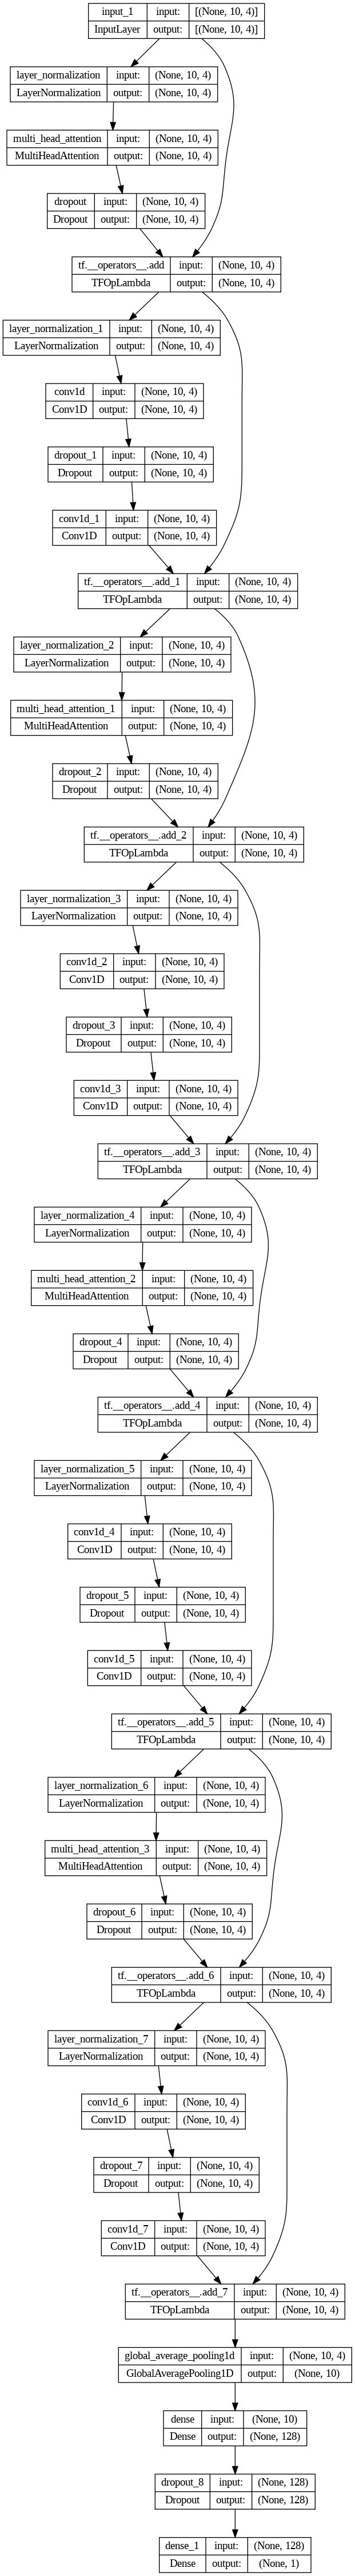

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

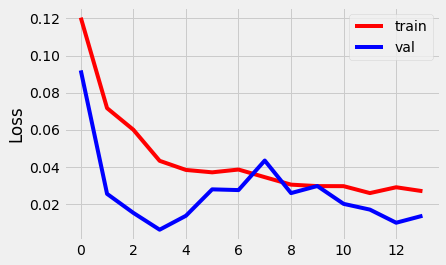

In [ ]:
train_error = history.history['loss']
val_error = history.history['val_loss']

plot_error(train_error,val_error)

In [ ]:
# Evaluating the model
mae, mse, rmse, r2_value, true,predicted = evaluate_model(model, test, timesteps)
print('\n')
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))

5/5 [==============================] - 1s 17ms/step


MAE = 0.06823474113197915
MSE = 0.006194970907416576
RMSE = 0.07870813749172684
R-Squared Score = 0.20991080563959796


In [ ]:
# Get each date data
train_date = train_data.index
val_date = val_data.index
test_date = test_data.index[timesteps:]

# Bring back onto original values
train_sc = sc.inverse_transform(train)
val_sc = sc.inverse_transform(val)
test_sc = sc.inverse_transform(test)

# Create empty fill so predicted data fits with scaler dimension
zeros_shape = test.shape[0] - timesteps
num_x_variables = len(variables) - 1
empty_fill = np.zeros((zeros_shape, num_x_variables))

# Transform back into original value
pred_tr = np.concatenate((empty_fill, predicted), axis=1)
pred_tr = sc.inverse_transform(pred_tr)

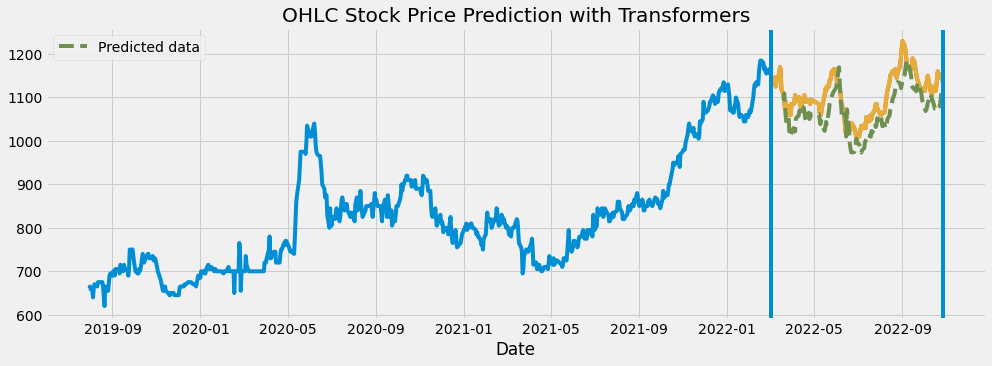

In [ ]:
# Figure size
plt.figure(figsize=(15, 5))

# Train data
plt.plot(train_date, train_sc[:, -1])

# Val data
plt.plot(val_date, val_sc[:, -1])

# Test data
plt.plot(test_data.index, test_sc[:, -1])
plt.plot(test_date, pred_tr[:, -1], label='Predicted data', linestyle='--')

# Boundaries
plt.axvline(np.max(train_date))
plt.axvline(np.max(val_date))

# Attributes
plt.title('OHLC Stock Price Prediction with Transformers')
plt.xlabel('Date')
plt.legend()
plt.show()

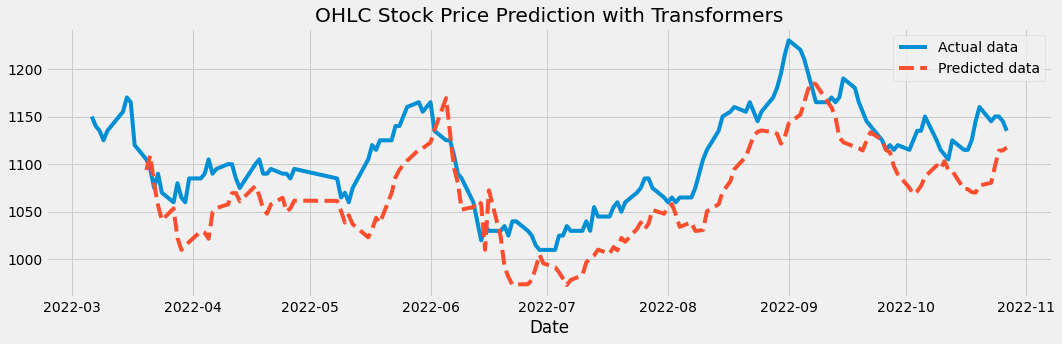

In [ ]:
plt.figure(figsize=(15, 5))

# Test data
plt.plot(test_data.index, test_sc[:, -1], label='Actual data')
plt.plot(test_date, pred_tr[:, -1], label='Predicted data', linestyle='--')

# Attributes
plt.title('OHLC Stock Price Prediction with Transformers')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()

In [ ]:
model.save(f'OHLC-Transformers.h5')

In [ ]:
output = pd.DataFrame(pred_tr, columns = variables)
dates = pd.DataFrame(test_sc, columns = variables)

output['Pred_Transformers'] =  output['Close']
output['Close'] =  dates['Close']
output = output[['Close', 'Pred_Transformers']]
output

,Close,Pred_Transformers
0,1150.0,1093.844147
1,1140.0,1109.102857
2,1135.0,1079.597217
3,1125.0,1056.861051
4,1135.0,1041.104364
...,...,...
144,1125.0,1080.422766
145,1115.0,1098.439895
146,1110.0,1114.186714
147,1105.0,1114.371026


In [ ]:
def ModelEvaluation(y_test, preds):

    # Evaluate the model
    mse = mean_squared_error(y_test, preds)
    rmse = sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print('\n')
    print('MAE = {}'.format(mae))
    print('MSE = {}'.format(mse))
    print('RMSE = {}'.format(rmse))
    print('R-Squared Score = {}'.format(r2))

    return mse, rmse, mae, r2

print("Model Evaluation After Invers Transform")
mse, rmse, mae, r = ModelEvaluation(output['Close'], output['Pred_Transformers'])

Model Evaluation After Invers Transform


MAE = 45.53806031310318
MSE = 3365.4207082830735
RMSE = 58.01224619236074
R-Squared Score = -0.3273482889705357


In [ ]:
output.to_csv(f'OHLC-Transformers.csv', index = False)

## Features OHLC + makro + mikro + VIX

In [ ]:
def create_ts_transformers(inputs, head_size, num_heads, ff_dim, dropout=0):
  x = tf.keras.layers.LayerNormalization()(inputs)
  x = tf.keras.layers.MultiHeadAttention(
      key_dim=head_size,
      num_heads=num_heads,
      dropout=dropout
  )(x, x)
  x = tf.keras.layers.Dropout(dropout)(x)
  res = x + inputs

  x = tf.keras.layers.LayerNormalization()(res)
  x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0
  ):
  inputs = tf.keras.Input(shape=input_shape)
  x = inputs
  for _ in range(num_transformer_blocks):
    x = create_ts_transformers(x, head_size, num_heads, ff_dim, dropout)
  
  x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = tf.keras.layers.Dense(dim, activation="relu")(x)
    x = tf.keras.layers.Dropout(mlp_dropout)(x)
  outputs = tf.keras.layers.Dense(1)(x)
  model = tf.keras.Model(inputs, outputs)

  return  model

In [ ]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
  X_test = []
  Y_test = []

  # Loop for testing data
  # Index: 0 (Open), 1 (High), 2 (Low), ...3 (Close)
  for i in range(timesteps,test.shape[0]):
      X_test.append(test[i-timesteps:i]) # List
      Y_test.append(test[i][-1]) # <== Index 3 (CLOSE)
  X_test,Y_test = np.array(X_test), np.array(Y_test) # Transform list to numpy array

  # Prediction Time !!!!
  Y_hat = model.predict(X_test)
  mae = mean_absolute_error(Y_test,Y_hat)
  mse = mean_squared_error(Y_test,Y_hat)
  rmse = sqrt(mse)
  r = r2_score(Y_test,Y_hat)
  return  mae, mse, rmse, r, Y_test, Y_hat

In [ ]:
# Plotting the predictions
def plot_data(Y_test,Y_hat,test_data=None):
  # date = test_data.reset_index()['Date']
  plt.plot(Y_test,c = 'r')
  plt.plot(Y_hat,c = 'y')
  plt.xlabel('Day')
  plt.ylabel('Price')
  plt.title('Stock Prediction Graph using Multivariate-LSTM model')
  plt.legend(['Actual','Predicted'],loc = 'lower right')
  plt.show()

In [ ]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
  plt.plot(train_loss,c = 'r')
  plt.plot(val_loss,c = 'b')
  plt.ylabel('Loss')
  plt.legend(['train','val'],loc = 'upper right')
  plt.show()

In [ ]:
# Load data and conversion date 
df = pd.read_csv(f"/content/drive/MyDrive/Datasets/New Project/Dataset/final_dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])
print(f'{np.min(df.Date)} until {np.max(df.Date)}')

# Extracting the series
df = df.set_index('Date')
df = df.dropna() # Drop menghindari Explosion Gradient (LSTM syarat: non NaN)

# Picking the multivariate series 
variables = ['Open', 'High', 'Low', 'Inflasi', 'Kurs', 'M2', 'Vix Open',
       'Vix High', 'Vix Low', 'Vix Close', 'ROE', 'NPM', 'PER', 'Close']
series = df[variables] 
print(series.shape)
print(series)

2019-07-30 00:00:00 until 2022-10-27 00:00:00
(795, 14)
              Open    High     Low   Inflasi     Kurs            M2  \
Date                                                                  
2019-07-30   655.0   670.0   655.0  3.371739  14034.0  5.935133e+06   
2019-07-31   660.0   685.0   660.0  3.379130  14026.0  5.934847e+06   
2019-08-01   660.0   685.0   660.0  3.386522  14098.0  5.934562e+06   
2019-08-04   665.0   670.0   645.0  3.393913  14164.5  5.937881e+06   
2019-08-05   655.0   655.0   630.0  3.401304  14231.0  5.941201e+06   
...            ...     ...     ...       ...      ...           ...   
2022-10-23  1160.0  1160.0  1145.0  5.950000  15247.0  7.890747e+06   
2022-10-24  1145.0  1150.0  1140.0  5.950000  15247.0  7.890747e+06   
2022-10-25  1150.0  1155.0  1140.0  5.950000  15247.0  7.890747e+06   
2022-10-26  1150.0  1165.0  1145.0  5.950000  15247.0  7.890747e+06   
2022-10-27  1145.0  1150.0  1135.0  5.950000  15247.0  7.890747e+06   

             Vix Ope

In [ ]:
# Note : 80% data training and 20% data testing
# Train Data
train_start = dt.date(2019,7,30)
train_end = dt.date(2022,3,3)
train_data = series.loc[train_start:train_end] # Output Train Data

# Validation Data
val_start = dt.date(2022,3,6)
val_end = dt.date(2022,10,27)
val_data = series.loc[val_start:val_end] # Output Validation Data

# Test Data
test_start = dt.date(2022,3,6)
test_end = dt.date(2022,10,27)
test_data = series.loc[test_start:test_end] # Output Test Data

print(f"Data train {train_start}:{train_end}")
print(f"Data validation {val_start}:{val_end}")
print(f"Data test {test_start}:{test_end}")
print()
print(train_data.shape,val_data.shape,test_data.shape)

# ROT: 70-20-10

Data train 2019-07-30:2022-03-03
Data validation 2022-03-06:2022-10-27
Data test 2022-03-06:2022-10-27

(636, 14) (159, 14) (159, 14)


In [ ]:
# Normalization
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(636, 14) (159, 14) (159, 14)


In [ ]:
# LSTM Hyperparameters (All Feature)
timesteps = 10
hl = [64]
lr = 0.001
batch_size = 128
num_epochs = 100


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 4)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 10, 4)       8           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 10, 4)       19460       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

In [ ]:
X_train = []
Y_train = []
X_val = []
Y_val = []

  # Loop for training data
  # Index: 0 (Open), 1 (High), 2 (Low), ...3 (Close)
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i]) # List
    Y_train.append(train[i][-1]) # <== Index 3 (CLOSE)
X_train, Y_train = np.array(X_train), np.array(Y_train) # Transform list to numpy array

  # Loop for val data
  # Index: 0 (Open), 1 (High), 2 (Low), ...3 (Close)
for i in range(timesteps,val.shape[0]):
    X_val.append(val[i-timesteps:i]) # List
    Y_val.append(val[i][-1]) # <== Index 3 (CLOSE)
X_val, Y_val = np.array(X_val), np.array(Y_val) # Transform list to numpy array


model = build_model(
    input_shape=X_train.shape[1:],
    head_size= 256,
    num_heads= 4,
    ff_dim= 4,
    num_transformer_blocks= 4,
    mlp_units= [128],
    mlp_dropout= 0.4,
    dropout= 0.25
  )

model.compile(
      loss="mean_squared_error",
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
  )

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
      X_train,
      Y_train,
      validation_data = (X_val, Y_val),
      epochs= 30,
      batch_size= 64,
      callbacks=callbacks
  )

Epoch 1/30
10/10 [==============================] - 7s 166ms/step - loss: 0.2603 - val_loss: 0.7842
Epoch 2/30
10/10 [==============================] - 1s 118ms/step - loss: 0.2169 - val_loss: 0.7943
Epoch 3/30
10/10 [==============================] - 1s 120ms/step - loss: 0.2063 - val_loss: 0.7553
Epoch 4/30
10/10 [==============================] - 1s 121ms/step - loss: 0.1947 - val_loss: 0.7364
Epoch 5/30
10/10 [==============================] - 1s 118ms/step - loss: 0.1805 - val_loss: 0.7052
Epoch 6/30
10/10 [==============================] - 2s 157ms/step - loss: 0.1618 - val_loss: 0.6573
Epoch 7/30
10/10 [==============================] - 2s 188ms/step - loss: 0.1425 - val_loss: 0.5835
Epoch 8/30
10/10 [==============================] - 1s 118ms/step - loss: 0.1156 - val_loss: 0.4790
Epoch 9/30
10/10 [==============================] - 1s 120ms/step - loss: 0.0852 - val_loss: 0.3570
Epoch 10/30
10/10 [==============================] - 1s 121ms/step - loss: 0.0660 - val_loss: 0.2509

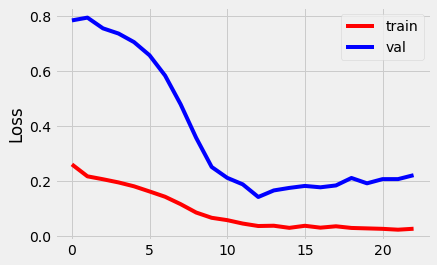

In [ ]:
train_error = history.history['loss']
val_error = history.history['val_loss']

plot_error(train_error,val_error)

In [ ]:
# Evaluating the model
mae, mse, rmse, r2_value, true,predicted = evaluate_model(model, test, timesteps)
print('\n')
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))

5/5 [==============================] - 1s 19ms/step


MAE = 0.332978048941695
MSE = 0.14173389840499687
RMSE = 0.37647562790305145
R-Squared Score = -17.07634342080581


In [ ]:
# Get each date data
train_date = train_data.index
val_date = val_data.index
test_date = test_data.index[timesteps:]

# Bring back onto original values
train_sc = sc.inverse_transform(train)
val_sc = sc.inverse_transform(val)
test_sc = sc.inverse_transform(test)

# Create empty fill so predicted data fits with scaler dimension
zeros_shape = test.shape[0] - timesteps
num_x_variables = len(variables) - 1
empty_fill = np.zeros((zeros_shape, num_x_variables))

# Transform back into original value
pred_tr2 = np.concatenate((empty_fill, predicted), axis=1)
pred_tr2 = sc.inverse_transform(pred_tr2)

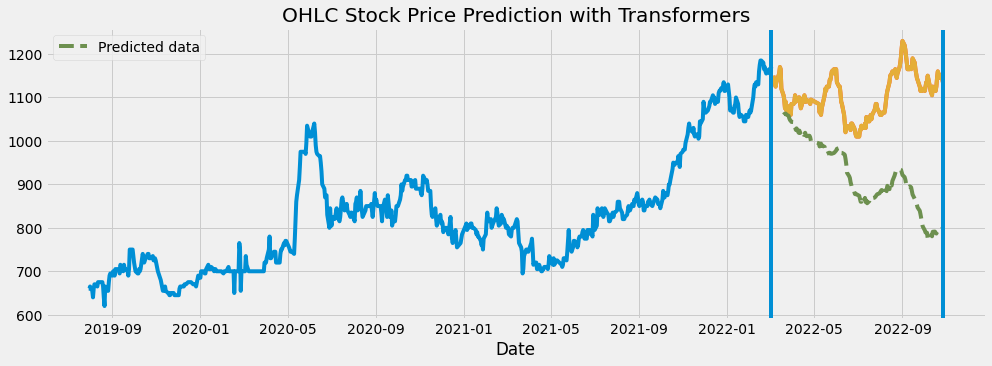

In [ ]:
# Figure size
plt.figure(figsize=(15, 5))

# Train data
plt.plot(train_date, train_sc[:, -1])

# Val data
plt.plot(val_date, val_sc[:, -1])

# Test data
plt.plot(test_data.index, test_sc[:, -1])
plt.plot(test_date, pred_tr2[:, -1], label='Predicted data', linestyle='--')

# Boundaries
plt.axvline(np.max(train_date))
plt.axvline(np.max(val_date))

# Attributes
plt.title('OHLC Stock Price Prediction with Transformers')
plt.xlabel('Date')
plt.legend()
plt.show()

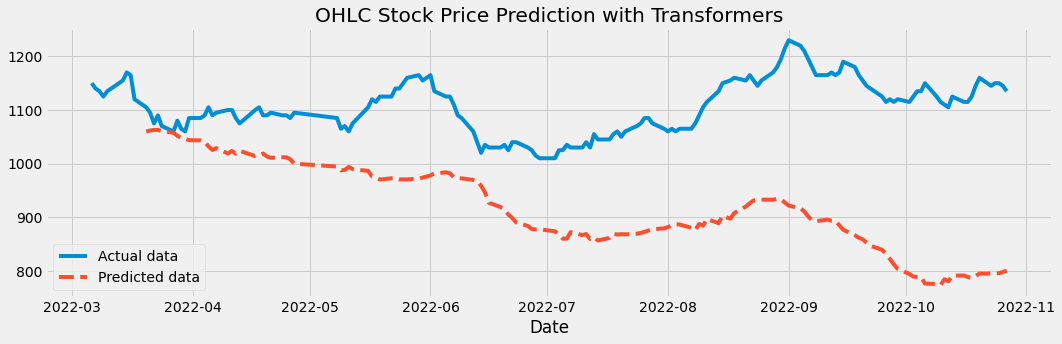

In [ ]:
plt.figure(figsize=(15, 5))

# Test data
plt.plot(test_data.index, test_sc[:, -1], label='Actual data')
plt.plot(test_date, pred_tr2[:, -1], label='Predicted data', linestyle='--')

# Attributes
plt.title('OHLC Stock Price Prediction with Transformers')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()

In [ ]:
model.save(f'OHLC-Transformers-2.h5')

In [ ]:
output = pd.DataFrame(pred_tr2, columns = variables)
dates = pd.DataFrame(test_sc, columns = variables)

output['Pred_Transformers'] =  output['Close']
output['Close'] =  dates['Close']
output = output[['Close', 'Pred_Transformers']]
output

,Close,Pred_Transformers
0,1150.0,1059.944213
1,1140.0,1061.649227
2,1135.0,1062.763250
3,1125.0,1062.869701
4,1135.0,1060.644720
...,...,...
144,1125.0,795.051598
145,1115.0,795.509584
146,1110.0,795.594836
147,1105.0,797.766641


In [ ]:
def ModelEvaluation(y_test, preds):

    # Evaluate the model
    mse = mean_squared_error(y_test, preds)
    rmse = sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print('\n')
    print('MAE = {}'.format(mae))
    print('MSE = {}'.format(mse))
    print('RMSE = {}'.format(rmse))
    print('R-Squared Score = {}'.format(r2))

    return mse, rmse, mae, r2

print("Model Evaluation After Invers Transform")
mse, rmse, mae, r = ModelEvaluation(output['Close'], output['Pred_Transformers'])

Model Evaluation After Invers Transform


MAE = 188.53528221581607
MSE = 44702.000471216874
RMSE = 211.42847601781762
R-Squared Score = -16.630819140380407


In [ ]:
output.to_csv(f'OHLC-Transformers-2.csv', index = False)

## Features OHLC + makro + mikro + VIX + Sentiment

In [ ]:
def create_ts_transformers(inputs, head_size, num_heads, ff_dim, dropout=0):
  x = tf.keras.layers.LayerNormalization()(inputs)
  x = tf.keras.layers.MultiHeadAttention(
      key_dim=head_size,
      num_heads=num_heads,
      dropout=dropout
  )(x, x)
  x = tf.keras.layers.Dropout(dropout)(x)
  res = x + inputs

  x = tf.keras.layers.LayerNormalization()(res)
  x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0
  ):
  inputs = tf.keras.Input(shape=input_shape)
  x = inputs
  for _ in range(num_transformer_blocks):
    x = create_ts_transformers(x, head_size, num_heads, ff_dim, dropout)
  
  x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = tf.keras.layers.Dense(dim, activation="relu")(x)
    x = tf.keras.layers.Dropout(mlp_dropout)(x)
  outputs = tf.keras.layers.Dense(1)(x)
  model = tf.keras.Model(inputs, outputs)

  return  model

In [ ]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
  X_test = []
  Y_test = []

  # Loop for testing data
  # Index: 0 (Open), 1 (High), 2 (Low), ...3 (Close)
  for i in range(timesteps,test.shape[0]):
      X_test.append(test[i-timesteps:i]) # List
      Y_test.append(test[i][-1]) # <== Index 3 (CLOSE)
  X_test,Y_test = np.array(X_test), np.array(Y_test) # Transform list to numpy array

  # Prediction Time !!!!
  Y_hat = model.predict(X_test)
  mae = mean_absolute_error(Y_test,Y_hat)
  mse = mean_squared_error(Y_test,Y_hat)
  rmse = sqrt(mse)
  r = r2_score(Y_test,Y_hat)
  return  mae, mse, rmse, r, Y_test, Y_hat

In [ ]:
# Plotting the predictions
def plot_data(Y_test,Y_hat,test_data=None):
  # date = test_data.reset_index()['Date']
  plt.plot(Y_test,c = 'r')
  plt.plot(Y_hat,c = 'y')
  plt.xlabel('Day')
  plt.ylabel('Price')
  plt.title('Stock Prediction Graph using Multivariate-LSTM model')
  plt.legend(['Actual','Predicted'],loc = 'lower right')
  plt.show()

In [ ]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
  plt.plot(train_loss,c = 'r')
  plt.plot(val_loss,c = 'b')
  plt.ylabel('Loss')
  plt.legend(['train','val'],loc = 'upper right')
  plt.show()

In [ ]:
# Load data and conversion date 
df = pd.read_csv(f"/content/drive/MyDrive/Datasets/New Project/Dataset/final_dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])
print(f'{np.min(df.Date)} until {np.max(df.Date)}')

# Extracting the series
df = df.set_index('Date')
df = df.dropna() # Drop menghindari Explosion Gradient (LSTM syarat: non NaN)

# Picking the multivariate series 
variables = ['Open', 'High', 'Low', 'Inflasi', 'Kurs', 'M2', 'Vix Open',
       'Vix High', 'Vix Low', 'Vix Close', 'ROE', 'NPM', 'PER',
       'Sentiment_Perang', 'Sentiment_Resesi', 'Sentiment_BBM', 'Close']
series = df[variables] 
print(series.shape)
print(series)

2019-07-30 00:00:00 until 2022-10-27 00:00:00
(795, 17)
              Open    High     Low   Inflasi     Kurs            M2  \
Date                                                                  
2019-07-30   655.0   670.0   655.0  3.371739  14034.0  5.935133e+06   
2019-07-31   660.0   685.0   660.0  3.379130  14026.0  5.934847e+06   
2019-08-01   660.0   685.0   660.0  3.386522  14098.0  5.934562e+06   
2019-08-04   665.0   670.0   645.0  3.393913  14164.5  5.937881e+06   
2019-08-05   655.0   655.0   630.0  3.401304  14231.0  5.941201e+06   
...            ...     ...     ...       ...      ...           ...   
2022-10-23  1160.0  1160.0  1145.0  5.950000  15247.0  7.890747e+06   
2022-10-24  1145.0  1150.0  1140.0  5.950000  15247.0  7.890747e+06   
2022-10-25  1150.0  1155.0  1140.0  5.950000  15247.0  7.890747e+06   
2022-10-26  1150.0  1165.0  1145.0  5.950000  15247.0  7.890747e+06   
2022-10-27  1145.0  1150.0  1135.0  5.950000  15247.0  7.890747e+06   

             Vix Ope

In [ ]:
# Note : 80% data training and 20% data testing
# Train Data
train_start = dt.date(2019,7,30)
train_end = dt.date(2022,3,3)
train_data = series.loc[train_start:train_end] # Output Train Data

# Validation Data
val_start = dt.date(2022,3,6)
val_end = dt.date(2022,10,27)
val_data = series.loc[val_start:val_end] # Output Validation Data

# Test Data
test_start = dt.date(2022,3,6)
test_end = dt.date(2022,10,27)
test_data = series.loc[test_start:test_end] # Output Test Data

print(f"Data train {train_start}:{train_end}")
print(f"Data validation {val_start}:{val_end}")
print(f"Data test {test_start}:{test_end}")
print()
print(train_data.shape,val_data.shape,test_data.shape)

# ROT: 70-20-10

Data train 2019-07-30:2022-03-03
Data validation 2022-03-06:2022-10-27
Data test 2022-03-06:2022-10-27

(636, 17) (159, 17) (159, 17)


In [ ]:
# Normalization
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(636, 17) (159, 17) (159, 17)


In [ ]:
# LSTM Hyperparameters (All Feature)
timesteps = 10
hl = [64]
lr = 0.001
batch_size = 128
num_epochs = 100


In [ ]:
X_train = []
Y_train = []
X_val = []
Y_val = []

  # Loop for training data
  # Index: 0 (Open), 1 (High), 2 (Low), ...3 (Close)
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i]) # List
    Y_train.append(train[i][-1]) # <== Index 3 (CLOSE)
X_train, Y_train = np.array(X_train), np.array(Y_train) # Transform list to numpy array

  # Loop for val data
  # Index: 0 (Open), 1 (High), 2 (Low), ...3 (Close)
for i in range(timesteps,val.shape[0]):
    X_val.append(val[i-timesteps:i]) # List
    Y_val.append(val[i][-1]) # <== Index 3 (CLOSE)
X_val, Y_val = np.array(X_val), np.array(Y_val) # Transform list to numpy array


model = build_model(
    input_shape=X_train.shape[1:],
    head_size= 256,
    num_heads= 4,
    ff_dim= 4,
    num_transformer_blocks= 4,
    mlp_units= [128],
    mlp_dropout= 0.4,
    dropout= 0.25
  )

model.compile(
      loss="mean_squared_error",
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
  )

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
      X_train,
      Y_train,
      validation_data = (X_val, Y_val),
      epochs= 30,
      batch_size= 64,
      callbacks=callbacks
  )

Epoch 1/30
10/10 [==============================] - 7s 177ms/step - loss: 0.1919 - val_loss: 0.6790
Epoch 2/30
10/10 [==============================] - 1s 127ms/step - loss: 0.1654 - val_loss: 0.5620
Epoch 3/30
10/10 [==============================] - 1s 126ms/step - loss: 0.1373 - val_loss: 0.3944
Epoch 4/30
10/10 [==============================] - 1s 124ms/step - loss: 0.0841 - val_loss: 0.2114
Epoch 5/30
10/10 [==============================] - 1s 127ms/step - loss: 0.0658 - val_loss: 0.1144
Epoch 6/30
10/10 [==============================] - 2s 169ms/step - loss: 0.0518 - val_loss: 0.0350
Epoch 7/30
10/10 [==============================] - 2s 185ms/step - loss: 0.0423 - val_loss: 0.0137
Epoch 8/30
10/10 [==============================] - 1s 125ms/step - loss: 0.0356 - val_loss: 0.0069
Epoch 9/30
10/10 [==============================] - 1s 123ms/step - loss: 0.0318 - val_loss: 0.0219
Epoch 10/30
10/10 [==============================] - 1s 122ms/step - loss: 0.0290 - val_loss: 0.0271

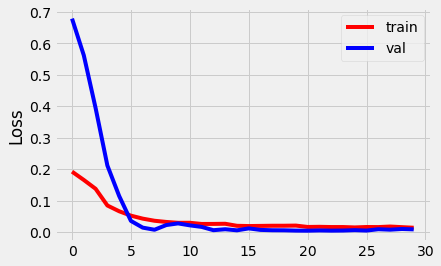

In [ ]:
train_error = history.history['loss']
val_error = history.history['val_loss']

plot_error(train_error,val_error)

In [ ]:
# Evaluating the model
mae, mse, rmse, r2_value, true,predicted = evaluate_model(model, test, timesteps)
print('\n')
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))

5/5 [==============================] - 0s 18ms/step


MAE = 0.07750297782539632
MSE = 0.008122352254920773
RMSE = 0.09012409364271451
R-Squared Score = -0.03590199942971517


In [ ]:
# Get each date data
train_date = train_data.index
val_date = val_data.index
test_date = test_data.index[timesteps:]

# Bring back onto original values
train_sc = sc.inverse_transform(train)
val_sc = sc.inverse_transform(val)
test_sc = sc.inverse_transform(test)

# Create empty fill so predicted data fits with scaler dimension
zeros_shape = test.shape[0] - timesteps
num_x_variables = len(variables) - 1
empty_fill = np.zeros((zeros_shape, num_x_variables))

# Transform back into original value
pred_tr3 = np.concatenate((empty_fill, predicted), axis=1)
pred_tr3 = sc.inverse_transform(pred_tr3)

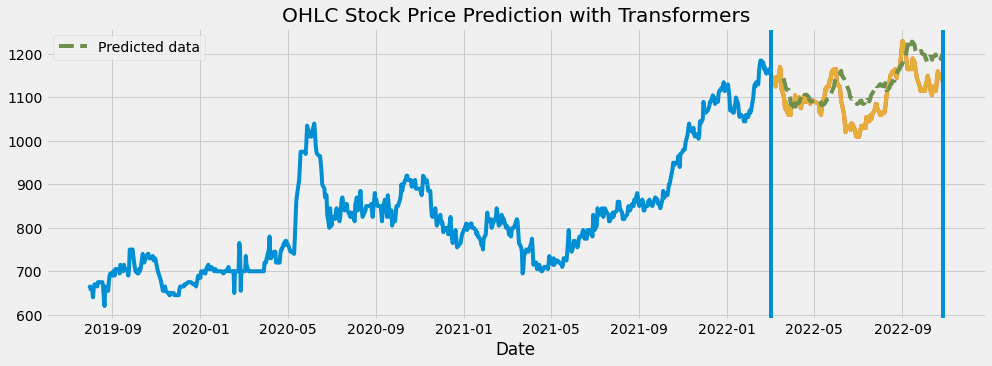

In [ ]:
# Figure size
plt.figure(figsize=(15, 5))

# Train data
plt.plot(train_date, train_sc[:, -1])

# Val data
plt.plot(val_date, val_sc[:, -1])

# Test data
plt.plot(test_data.index, test_sc[:, -1])
plt.plot(test_date, pred_tr3[:, -1], label='Predicted data', linestyle='--')

# Boundaries
plt.axvline(np.max(train_date))
plt.axvline(np.max(val_date))

# Attributes
plt.title('OHLC Stock Price Prediction with Transformers')
plt.xlabel('Date')
plt.legend()
plt.show()

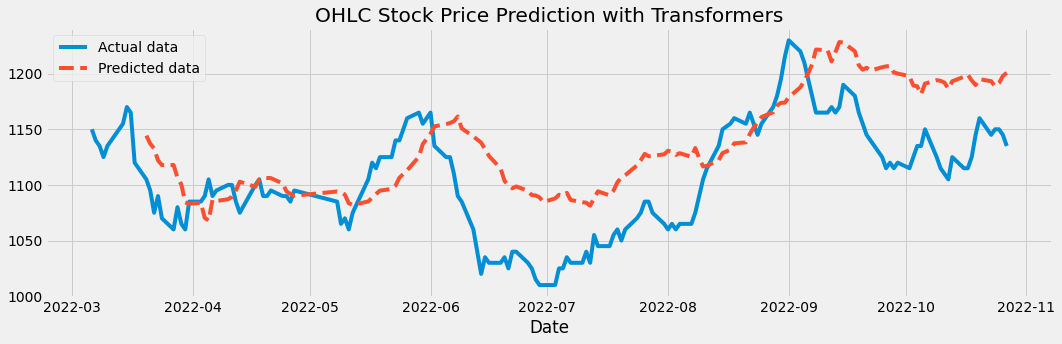

In [ ]:
plt.figure(figsize=(15, 5))

# Test data
plt.plot(test_data.index, test_sc[:, -1], label='Actual data')
plt.plot(test_date, pred_tr3[:, -1], label='Predicted data', linestyle='--')

# Attributes
plt.title('OHLC Stock Price Prediction with Transformers')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()

In [ ]:
model.save(f'OHLC-Transformers-3.h5')

In [ ]:
output = pd.DataFrame(pred_tr3, columns = variables)
dates = pd.DataFrame(test_sc, columns = variables)

output['Pred_Transformers'] =  output['Close']
output['Close'] =  dates['Close']
output = output[['Close', 'Pred_Transformers']]
output

,Close,Pred_Transformers
0,1150.0,1144.320120
1,1140.0,1137.075806
2,1135.0,1132.675619
3,1125.0,1122.033266
4,1135.0,1117.856927
...,...,...
144,1125.0,1193.204097
145,1115.0,1188.703620
146,1110.0,1191.481875
147,1105.0,1197.875584


In [ ]:
def ModelEvaluation(y_test, preds):

    # Evaluate the model
    mse = mean_squared_error(y_test, preds)
    rmse = sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print('\n')
    print('MAE = {}'.format(mae))
    print('MSE = {}'.format(mse))
    print('RMSE = {}'.format(rmse))
    print('R-Squared Score = {}'.format(r2))

    return mse, rmse, mae, r2

print("Model Evaluation After Invers Transform")
mse, rmse, mae, r = ModelEvaluation(output['Close'], output['Pred_Transformers'])

Model Evaluation After Invers Transform


MAE = 41.12890198926797
MSE = 2421.794278565007
RMSE = 49.211729075140276
R-Squared Score = 0.04482536641552326


In [ ]:
output.to_csv(f'OHLC-Transformers-3.csv', index = False)